In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Function to load images from a directory and resize them to a common size
def load_images_from_folder(folder, target_size):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

In [4]:
dadata_folder = '/content/drive/MyDrive/' #replace with the path to dataset folder
blur_images = load_images_from_folder('/content/drive/MyDrive/ds/Blur', (224, 224))
non_blur_images = load_images_from_folder('/content/drive/MyDrive/ds/nonblur', (224, 224))

In [5]:
# Define labels
blur_labels = np.ones(len(blur_images))
non_blur_labels = np.zeros(len(non_blur_images))

In [6]:
# Combine images and labels
X = np.array(blur_images + non_blur_images)
y = np.concatenate((blur_labels, non_blur_labels), axis=0)

In [7]:
# Shuffle the data
X, y = shuffle(X, y, random_state=42)

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [9]:
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Save the model weights
model.save_weights("blur_classification_model.h5")




In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
20/20 [==============================] - 99s 5s/step - loss: 0.6440 - accuracy: 0.6333 - val_loss: 0.5012 - val_accuracy: 0.7476
Epoch 2/25
20/20 [==============================] - 84s 4s/step - loss: 0.4902 - accuracy: 0.7937 - val_loss: 0.3825 - val_accuracy: 0.8524
Epoch 3/25
20/20 [==============================] - 84s 4s/step - loss: 0.3846 - accuracy: 0.8397 - val_loss: 0.4471 - val_accuracy: 0.7810
Epoch 4/25
20/20 [==============================] - 80s 4s/step - loss: 0.3693 - accuracy: 0.8619 - val_loss: 0.3350 - val_accuracy: 0.8762
Epoch 5/25
20/20 [==============================] - 82s 4s/step - loss: 0.2924 - accuracy: 0.8873 - val_loss: 0.2819 - val_accuracy: 0.9000
Epoch 6/25
20/20 [==============================] - 81s 4s/step - loss: 0.2705 - accuracy: 0.9032 - val_loss: 0.3508 - val_accuracy: 0.8524
Epoch 7/25
20/20 [==============================] - 82s 4s/step - loss: 0.2649 - accuracy: 0.9000 - val_loss: 0.2788 - val_accuracy: 0.8857
Epoch 8/25
20/20 [==

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 6s 817ms/step - loss: 0.4458 - accuracy: 0.8952


In [15]:
print('Test accuracy:', test_acc)

Test accuracy: 0.8952381014823914


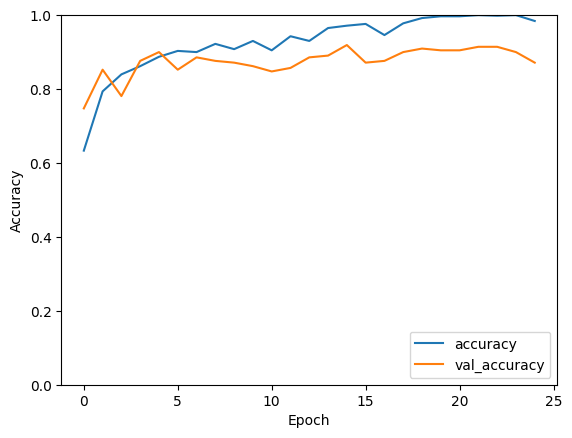

In [16]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Get predictions for the test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Print the classification report
print(classification_report(y_test, y_pred_binary))


7/7 [==============================] - 8s 1s/step
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83        61
         1.0       0.94      0.91      0.92       149

    accuracy                           0.90       210
   macro avg       0.87      0.89      0.88       210
weighted avg       0.90      0.90      0.90       210



In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Predict probabilities for test set
y_pred_prob = model.predict(X_test)


7/7 [==============================] - 7s 887ms/step


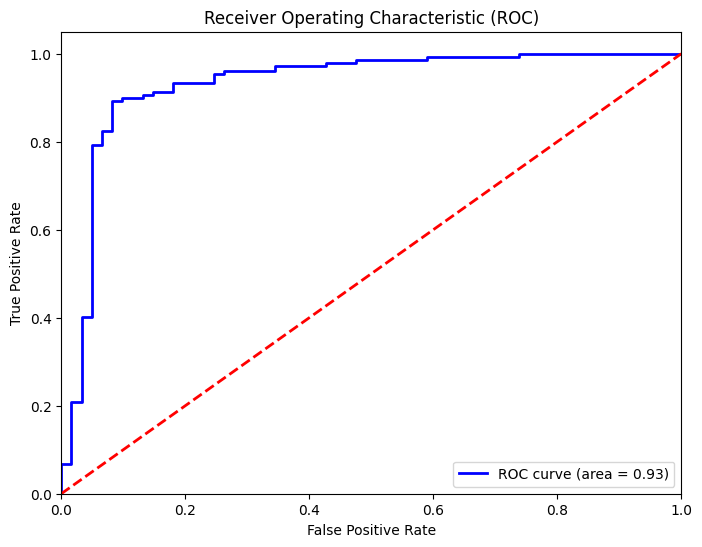

In [20]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

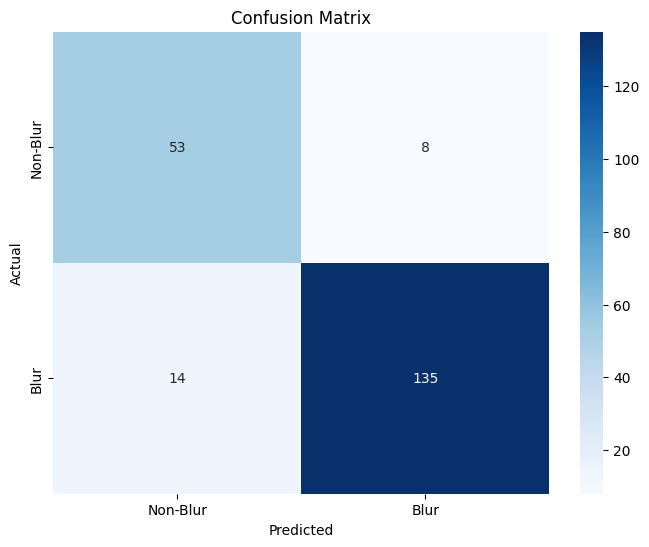

In [21]:
# Generate confusion matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Blur', 'Blur'], yticklabels=['Non-Blur', 'Blur'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Performing on your data- folder with ungrouped images

In [22]:
#Functioning the classification model on your required data

import os
import cv2
import numpy as np
import shutil

# Function to classify unseen images and save non-blur images
def classify_and_save_images(images_folder, target_size, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for filename in os.listdir(images_folder):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            original_img = img.copy()
            img_resized = cv2.resize(img, target_size)
            img_resized = np.expand_dims(img_resized, axis=0)
            img_resized = img_resized / 255.0  # Normalize
            prediction = model.predict(img_resized)
            if prediction[0][0] < 0.5:  # Non-blur
                cv2.imwrite(os.path.join(save_folder, filename), original_img)

# Define the folders
unseen_images_folder = '/content/drive/MyDrive/dataset'
save_non_blur_folder = '/content/drive/MyDrive/sharps'

# Classify unseen images and save non-blur images
classify_and_save_images(unseen_images_folder, (224, 224), save_non_blur_folder)



1/1 [==============================] - 0s 47ms/step


In [23]:
import os

# Function to count the number of files in a folder
def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Define the folder
sharp_folder = '/content/drive/MyDrive/sharps'

# Count the number of files in the sharp folder
num_files = count_files_in_folder(sharp_folder)
print(f'The number of files in the sharp folder: {num_files}')


The number of files in the sharp folder: 244


# Selecting the Best shot among group of duplicates

1/1 [==============================] - 0s 470ms/step
Best shot 1 saved to /content/drive/MyDrive/best/161 (2).png
Best shot 2 saved to /content/drive/MyDrive/best/191 (2).png
Best shot 3 saved to /content/drive/MyDrive/best/212 (2).png
Best shot 4 saved to /content/drive/MyDrive/best/185 (2).png
Best shot 5 saved to /content/drive/MyDrive/best/182 (2).png
Best shot 6 saved to /content/drive/MyDrive/best/160 (2).png
Best shot 7 saved to /content/drive/MyDrive/best/180.png
Best shot 8 saved to /content/drive/MyDrive/best/180 (2).png
Best shot 9 saved to /content/drive/MyDrive/best/165 (2).png
Best shot 10 saved to /content/drive/MyDrive/best/213 (2).png
Best shot 11 saved to /content/drive/MyDrive/best/192 (2).png
Best shot 12 saved to /content/drive/MyDrive/best/197 (2).png
Best shot 13 saved to /content/drive/MyDrive/best/196 (2).png
Best shot 14 saved to /content/drive/MyDrive/best/181 (2).png
Best shot 15 saved to /content/drive/MyDrive/best/163 (2).png
Best shot 16 saved to /content

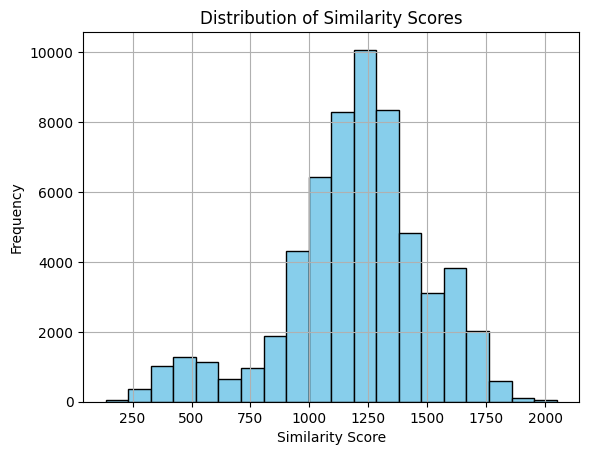

In [24]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to extract features from images using VGG16 model
def extract_features(image_paths):
    features = []
    for img_path in image_paths:
        img = preprocess_image(img_path)
        feature = model.predict(img)
        features.append(feature.flatten())
    return np.array(features)

# Function to calculate similarity between images
def calculate_similarity(img1, img2):
    return np.linalg.norm(img1 - img2)

# Function to select the best shot for each group of duplicates and save them to an output folder
def select_best_shot_for_folder(dataset_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read image paths
    image_paths = []
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                image_paths.append(os.path.join(root, file))

    # Extract features using VGG16 model
    features = extract_features(image_paths)

    total_images = len(image_paths)
    correct_predictions = 0
    similarities = []

    for i, img_path in enumerate(image_paths):
        min_similarity = float('inf')
        best_shot_path = None

        for j, other_img_path in enumerate(image_paths):
            if i != j:
                similarity = calculate_similarity(features[i], features[j])
                similarities.append(similarity)
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_shot_path = other_img_path

        filename = os.path.basename(best_shot_path)
        shutil.copy(best_shot_path, os.path.join(output_folder, filename))

        if filename == f"best_shot_{i}.jpg":  # Assuming ground truth labels are in the format "best_shot_0.jpg", "best_shot_1.jpg", etc.
            correct_predictions += 1

        print(f"Best shot {i+1} saved to {output_folder}/{filename}")

    # Visualize distribution of similarity scores
    plt.hist(similarities, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
dataset_folder = "/content/drive/MyDrive/sharps"  # Replace with the path to your dataset folder
output_folder = "/content/drive/MyDrive/best"  # Replace with the path to your output folder (make sure you have created this folder)
select_best_shot_for_folder(dataset_folder, output_folder)

In [25]:
import os

# Function to count the number of files in a folder
def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Define the folder
best_folder = '/content/drive/MyDrive/best'

# Count the number of files in the sharp folder
num_files = count_files_in_folder(best_folder)
print(f'The number of files in the output folder: {num_files}')

The number of files in the output folder: 166
